### Detection of fraudulent transactions in the merged fraud data

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor

In [2]:
df = pd.read_csv('C:/Users/elbet/OneDrive/Desktop/Ten/week8&9/github/Fraud_detection/cleaned_data/merged_data.csv')
df.head()

,user_id,signup_time,purchase_time,purchase_value,device_id,sex,age,ip_address,class,time_diff,...,country_United States,country_Uruguay,country_Uzbekistan,country_Vanuatu,country_Venezuela,country_Viet Nam,country_Virgin Islands (U.S.),country_Yemen,country_Zambia,country_Zimbabwe
0,247547,2015-06-28 03:00:34,2015-08-09 03:57:29,47,KIXYSVCHIPQBR,0,30,1.677886e+07,0,1008.948611,...,False,False,False,False,False,False,False,False,False,False
1,220737,2015-01-28 14:21:11,2015-02-11 20:28:28,15,PKYOWQKWGJNJI,0,34,1.684205e+07,0,342.121389,...,False,False,False,False,False,False,False,False,False,False
2,390400,2015-03-19 20:49:09,2015-04-11 23:41:23,44,LVCSXLISZHVUO,1,29,1.684366e+07,0,554.870556,...,False,False,False,False,False,False,False,False,False,False
3,69592,2015-02-24 06:11:57,2015-05-23 16:40:14,55,UHAUHNXXUADJE,0,30,1.693873e+07,0,2122.471389,...,False,False,False,False,False,False,False,False,False,False
4,174987,2015-07-07 12:58:11,2015-11-03 04:04:30,51,XPGPMOHIDRMGE,0,37,1.697198e+07,0,2847.105278,...,False,False,False,False,False,False,False,False,False,False


##### Visualize class distribution

class
0    116878
1     12268
Name: count, dtype: int64


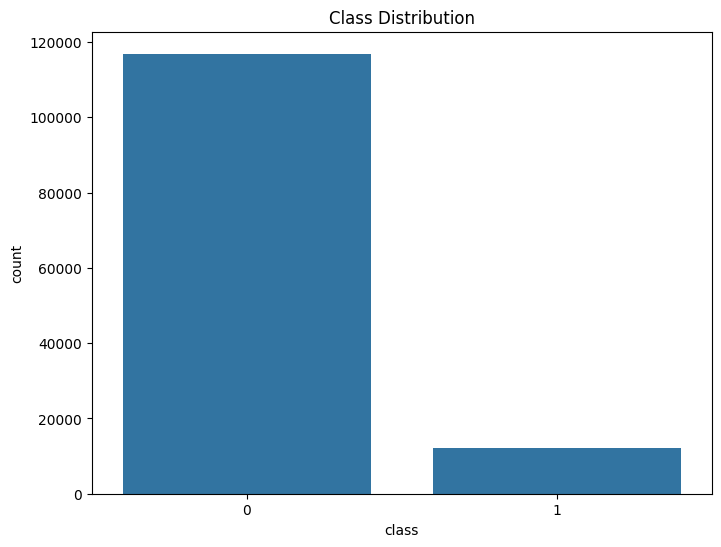

In [3]:
# Visualize Class distribution
class_counts = df['class'].value_counts()
print(class_counts)

# Visualize class distribution
plt.figure(figsize=(8, 6))
sns.countplot(x='class', data=df)
plt.title('Class Distribution')
plt.show()

##### Feature-Target Separation and Data Splitting

##### Using SMOTE (Synthetic Minority Over-sampling Technique) to generate synthetic data

In [9]:
df['signup_time'] = pd.to_datetime(df['signup_time'], errors='coerce')
df['purchase_time'] = pd.to_datetime(df['purchase_time'], errors='coerce')

print(df['signup_time'].isna().sum(), "NaT values in signup_time")
print(df['purchase_time'].isna().sum(), "NaT values in purchase_time")


0 NaT values in signup_time
0 NaT values in purchase_time


In [11]:
from imblearn.over_sampling import SMOTE
# Feature extraction from 'signup_time' and 'purchase_time'
df['signup_year'] = df['signup_time'].dt.year
df['signup_month'] = df['signup_time'].dt.month
df['signup_day'] = df['signup_time'].dt.day
df['signup_hour'] = df['signup_time'].dt.hour

df['purchase_year'] = df['purchase_time'].dt.year
df['purchase_month'] = df['purchase_time'].dt.month
df['purchase_day'] = df['purchase_time'].dt.day
df['purchase_hour'] = df['purchase_time'].dt.hour


# Optionally drop the original datetime columns
X = df.drop(['signup_time', 'purchase_time', 'device_id'], axis=1)

# Apply SMOTE
smote = SMOTE(sampling_strategy='auto', random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)


X = X_resampled
y = y_resampled

In [12]:
# Check the column names of the resampled feature matrix
print(X.columns)


Index(['user_id', 'purchase_value', 'sex', 'age', 'ip_address', 'class',
       'time_diff', 'lower_bound_ip_address', 'upper_bound_ip_address',
       'transaction_count',
       ...
       'signup_timestamp', 'purchase_timestamp', 'signup_year', 'signup_month',
       'signup_day', 'signup_hour', 'purchase_year', 'purchase_month',
       'purchase_day', 'purchase_hour'],
      dtype='object', length=209)


In [13]:

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

##### Scaling the Features

In [14]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

##### Training a Logistic Regression Model

In [15]:
Logistic_regression_m = LogisticRegression()
Logistic_regression_m.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = Logistic_regression_m.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, y_pred_lr))
print(classification_report(y_test, y_pred_lr))
print("Accuracy:", accuracy_score(y_test, y_pred_lr))
print("Precision:", precision_score(y_test, y_pred_lr))
print("Recall:", recall_score(y_test, y_pred_lr))
print("F1-Score:", f1_score(y_test, y_pred_lr))

[[23177     0]
 [    0 23575]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23177
           1       1.00      1.00      1.00     23575

    accuracy                           1.00     46752
   macro avg       1.00      1.00      1.00     46752
weighted avg       1.00      1.00      1.00     46752

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


##### Training a Random forest model

In [16]:
from sklearn.ensemble import RandomForestClassifier

random_forest_m = RandomForestClassifier(class_weight='balanced')
random_forest_m.fit(X, y)

RFM_y_pred_lr = random_forest_m.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, RFM_y_pred_lr))
print(classification_report(y_test, RFM_y_pred_lr))
print("Accuracy:", accuracy_score(y_test, RFM_y_pred_lr))
print("Precision:", precision_score(y_test, RFM_y_pred_lr))
print("Recall:", recall_score(y_test, RFM_y_pred_lr))
print("F1-Score:", f1_score(y_test, RFM_y_pred_lr))

c:\Users\elbet\miniconda3\envs\elbetel\lib\site-packages\sklearn\base.py:493: UserWarning: X does not have valid feature names, but RandomForestClassifier was fitted with feature names
  warnings.warn(


[[17781  5396]
 [    0 23575]]
              precision    recall  f1-score   support

           0       1.00      0.77      0.87     23177
           1       0.81      1.00      0.90     23575

    accuracy                           0.88     46752
   macro avg       0.91      0.88      0.88     46752
weighted avg       0.91      0.88      0.88     46752

Accuracy: 0.8845824777549623
Precision: 0.8137447792620206
Recall: 1.0
F1-Score: 0.8973090244737943


##### Training a Gradient Boosting Model

In [17]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import classification_report

gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=3, random_state=42)
gb_model.fit(X_train, y_train)


GBC_y_pred = gb_model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, GBC_y_pred))
print(classification_report(y_test, GBC_y_pred))
print("Accuracy:", accuracy_score(y_test, GBC_y_pred))
print("Precision:", precision_score(y_test, GBC_y_pred))
print("Recall:", recall_score(y_test, GBC_y_pred))
print("F1-Score:", f1_score(y_test, GBC_y_pred))

[[23177     0]
 [    0 23575]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23177
           1       1.00      1.00      1.00     23575

    accuracy                           1.00     46752
   macro avg       1.00      1.00      1.00     46752
weighted avg       1.00      1.00      1.00     46752

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0


##### Training a DecisionTree Model

In [18]:
from sklearn.tree import DecisionTreeClassifier
# Initialize the Decision Tree model
dt_model = DecisionTreeClassifier(random_state=42)

# Train the model
dt_model.fit(X_train, y_train)

DT_y_pred = gb_model.predict(X_test)

# Evaluate the model
print(confusion_matrix(y_test, DT_y_pred))
print(classification_report(y_test, DT_y_pred))
print("Accuracy:", accuracy_score(y_test, DT_y_pred))
print("Precision:", precision_score(y_test, DT_y_pred))
print("Recall:", recall_score(y_test, DT_y_pred))
print("F1-Score:", f1_score(y_test, DT_y_pred))

[[23177     0]
 [    0 23575]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     23177
           1       1.00      1.00      1.00     23575

    accuracy                           1.00     46752
   macro avg       1.00      1.00      1.00     46752
weighted avg       1.00      1.00      1.00     46752

Accuracy: 1.0
Precision: 1.0
Recall: 1.0
F1-Score: 1.0
